In [13]:
import os
# Configura API y token de QCI
os.environ['QCI_API_URL'] = 'https://api.qci-prod.com'  
os.environ['QCI_TOKEN'] = 'TOKEN'


In [24]:
import networkx as nx
import numpy as np

# Grafo más grande, similar a los usados en D-Wave
G = nx.random_regular_graph(d=3, n=80, seed=68)  # D=3, N=28

# Crear la matriz QUBO
n = G.number_of_nodes()
Q = np.zeros((n, n))

for u, v in G.edges():
    Q[u, v] += 1
    Q[v, u] += 1
    Q[u, u] -= 1
    Q[v, v] -= 1

print("Matriz QUBO lista para enviar.")


Matriz QUBO lista para enviar.


In [25]:
import qci_client as qc

# Crear un cliente QCI
client = qc.QciClient()

# Definir el QUBO
file_def = {
    "file_name": "max-cut-example",
    "file_config": {
        "qubo": {
            "data": Q
        }
    }
}


response = client.upload_file(file=file_def)

file_id = response["file_id"]
print(f"File ID: {file_id}")


# Crear el trabajo y enviarlo a QCi
job_body = client.build_job_body(
    job_type="sample-qubo",  
    qubo_file_id=file_id,
    job_params={"device_type": "dirac-1", "num_samples": 20}
)
job_response = client.process_job(job_body=job_body)


# Ver el ID del trabajo
job_id = job_response.get("job_info", {}).get("job_id", "Desconocido")
print(f"Trabajo enviado con ID: {job_id}")


File ID: 6807f5b05e08552632286ccc
2025-04-22 22:01:53 - Dirac allocation balance = 326 s
2025-04-22 22:01:53 - Job submitted: job_id='6807f5b16f2d98bd02a35ccb'
2025-04-22 22:01:54 - QUEUED
2025-04-22 22:01:56 - RUNNING
2025-04-22 22:06:33 - COMPLETED
2025-04-22 22:06:36 - Dirac allocation balance = 314 s
Trabajo enviado con ID: 6807f5b16f2d98bd02a35ccb


In [26]:
import time


job_status = client.get_job_status(job_id=job_id)
#job_status = client.get_job_status(job_id=job_id)
while job_status["status"] not in ["COMPLETED", "FAILED"]:
    print(f"Estado del trabajo: {job_status['status']}")
    time.sleep(5)
    job_status = client.get_job_status(job_id=job_id)
    #job_status = client.get_job_status(job_id=job_id)


if job_status["status"] == "COMPLETED":
    results = client.get_job_results(job_id=job_id)
    #results = client.get_job_status(job_id=job_id)
    print("Resultados obtenidos:")
    print(results)
else:
    print("El trabajo falló.")


Resultados obtenidos:
{'job_info': {'job_id': '6807f5b16f2d98bd02a35ccb', 'job_submission': {'problem_config': {'quadratic_unconstrained_binary_optimization': {'qubo_file_id': '6807f5b05e08552632286ccc'}}, 'device_config': {'dirac-1': {'num_samples': 20}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-04-22T20:01:53.775Z', 'queued_at_rfc3339nano': '2025-04-22T20:01:53.776Z', 'running_at_rfc3339nano': '2025-04-22T20:01:54.349Z', 'completed_at_rfc3339nano': '2025-04-22T20:06:33.282Z'}, 'job_result': {'file_id': '6807f6c95e08552632286cce', 'device_usage_s': 12}}, 'status': 'COMPLETED', 'results': {'counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'energies': [-105, -105, -105, -105, -105, -105, -105, -105, -105, -105, -105, -104, -104, -104, -104, -104, -104, -104, -103, -102], 'solutions': [[0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,

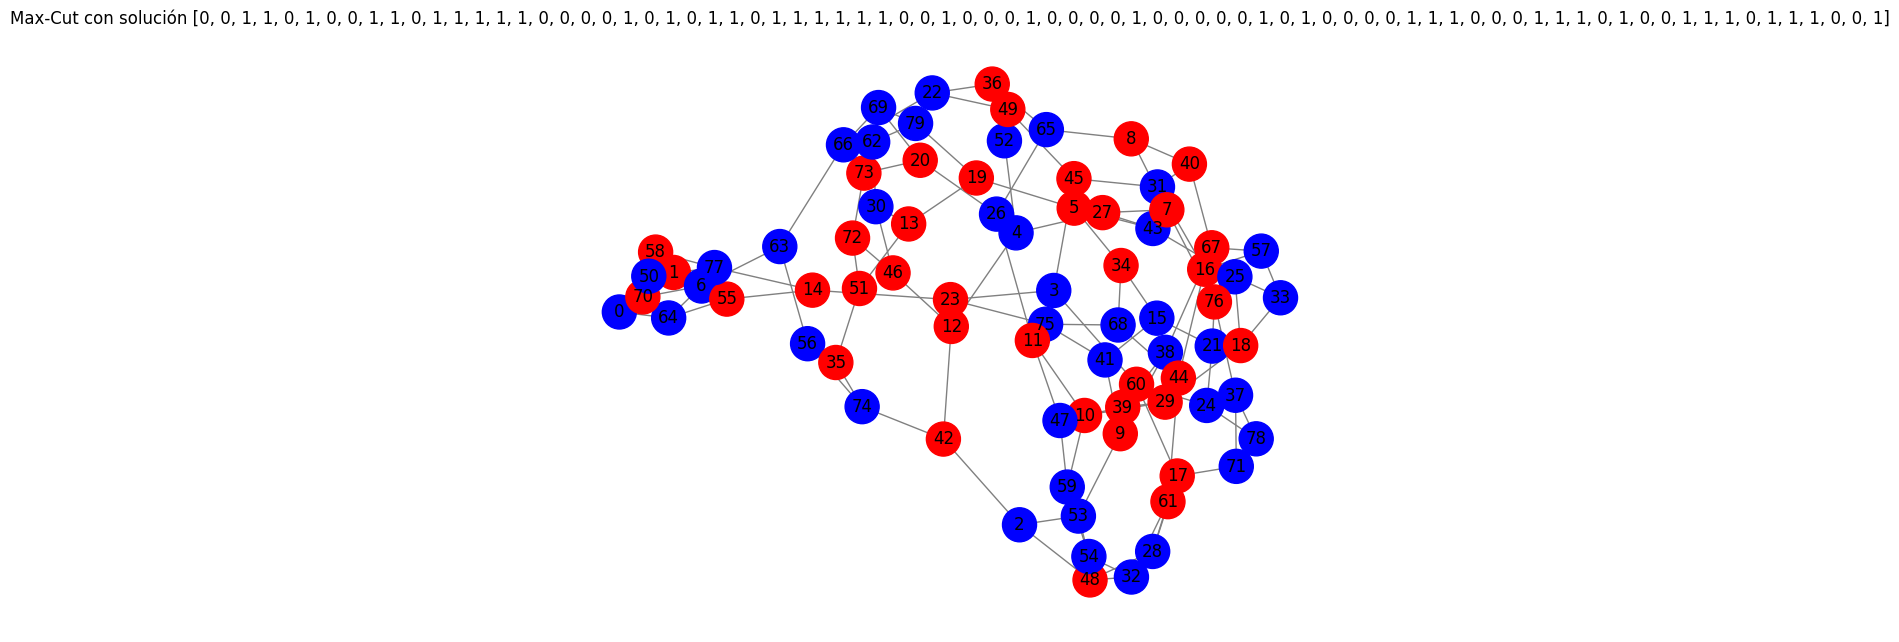

In [27]:
import matplotlib.pyplot as plt

# Obtener la mejor solución del resultado
solutions = results["results"]["solutions"]
best_solution = solutions[0]  # Puedes cambiar a otra si quieres ver más

# Asegurar que G es el mismo grafo usado para crear el QUBO
# (ya debería estar definido como nx.random_regular_graph(...) antes)

# Colorear los nodos según su valor en la solución (1 = rojo, 0 = azul)
node_colors = ['red' if bit == 1 else 'blue' for bit in best_solution]

# Dibujar el grafo original G
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # Fijar layout para que sea estable
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=600)
plt.title(f"Max-Cut con solución {best_solution}")
plt.show()


In [28]:
def compute_cut_size(G, solution):
    return sum(1 for u, v in G.edges() if solution[u] != solution[v])

cut_value = compute_cut_size(G, best_solution)
print(f"Valor del corte: {cut_value}")


Valor del corte: 105


In [29]:
def compute_cut_size(G, solution):
    return sum(1 for u, v in G.edges() if solution[u] != solution[v])

solutions = results["results"]["solutions"]

best_cut_value = 0
best_index = 0

for idx, sol in enumerate(solutions):
    cut_val = compute_cut_size(G, sol)
    print(f"Solución {idx}: corte = {cut_val}")
    
    if cut_val > best_cut_value:
        best_cut_value = cut_val
        best_index = idx

print(f"\n🔝 Mejor corte encontrado: {best_cut_value}, en la solución #{best_index}")


Solución 0: corte = 105
Solución 1: corte = 105
Solución 2: corte = 105
Solución 3: corte = 105
Solución 4: corte = 105
Solución 5: corte = 105
Solución 6: corte = 105
Solución 7: corte = 105
Solución 8: corte = 105
Solución 9: corte = 105
Solución 10: corte = 105
Solución 11: corte = 104
Solución 12: corte = 104
Solución 13: corte = 104
Solución 14: corte = 104
Solución 15: corte = 104
Solución 16: corte = 104
Solución 17: corte = 104
Solución 18: corte = 103
Solución 19: corte = 102

🔝 Mejor corte encontrado: 105, en la solución #0


In [ ]:
import networkx as nx
import numpy as np

# Grafo más grande, similar a los usados en D-Wave
G = nx.random_regular_graph(d=3, n=80, seed=68)  # D=3, N=28

# Crear la matriz QUBO
n = G.number_of_nodes()
Q = np.zeros((n, n))

for u, v in G.edges():
    Q[u, v] += 1
    Q[v, u] += 1
    Q[u, u] -= 1
    Q[v, v] -= 1

print("Matriz QUBO lista para enviar.")

In [ ]:
import qci_client as qc

# Crear un cliente QCI
client = qc.QciClient()

# Definir el QUBO
file_def = {
    "file_name": "max-cut-example",
    "file_config": {
        "qubo": {
            "data": Q
        }
    }
}


response = client.upload_file(file=file_def)

file_id = response["file_id"]
print(f"File ID: {file_id}")


# Crear el trabajo y enviarlo a QCi
job_body = client.build_job_body(
    job_type="sample-qubo",  
    qubo_file_id=file_id,
    job_params={"device_type": "dirac-1", "num_samples": 20}
)
job_response = client.process_job(job_body=job_body)


# Ver el ID del trabajo
job_id = job_response.get("job_info", {}).get("job_id", "Desconocido")
print(f"Trabajo enviado con ID: {job_id}")


In [ ]:
import qci_client as qc

# Crear un cliente QCI
client = qc.QciClient()

# Definir el QUBO
file_def = {
    "file_name": "max-cut-example",
    "file_config": {
        "qubo": {
            "data": Q
        }
    }
}


response = client.upload_file(file=file_def)

file_id = response["file_id"]
print(f"File ID: {file_id}")


# Crear el trabajo y enviarlo a QCi
job_body = client.build_job_body(
    job_type="sample-qubo",  
    qubo_file_id=file_id,
    job_params={"device_type": "dirac-1", "num_samples": 20}
)
job_response = client.process_job(job_body=job_body)


# Ver el ID del trabajo
job_id = job_response.get("job_info", {}).get("job_id", "Desconocido")
print(f"Trabajo enviado con ID: {job_id}")


In [ ]:
import time


job_status = client.get_job_status(job_id=job_id)
#job_status = client.get_job_status(job_id=job_id)
while job_status["status"] not in ["COMPLETED", "FAILED"]:
    print(f"Estado del trabajo: {job_status['status']}")
    time.sleep(5)
    job_status = client.get_job_status(job_id=job_id)
    #job_status = client.get_job_status(job_id=job_id)


if job_status["status"] == "COMPLETED":
    results = client.get_job_results(job_id=job_id)
    #results = client.get_job_status(job_id=job_id)
    print("Resultados obtenidos:")
    print(results)
else:
    print("El trabajo falló.")


In [ ]:
import matplotlib.pyplot as plt

# Obtener la mejor solución del resultado
solutions = results["results"]["solutions"]
best_solution = solutions[0]  # Puedes cambiar a otra si quieres ver más

# Asegurar que G es el mismo grafo usado para crear el QUBO
# (ya debería estar definido como nx.random_regular_graph(...) antes)

# Colorear los nodos según su valor en la solución (1 = rojo, 0 = azul)
node_colors = ['red' if bit == 1 else 'blue' for bit in best_solution]

# Dibujar el grafo original G
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # Fijar layout para que sea estable
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=600)
plt.title(f"Max-Cut con solución {best_solution}")
plt.show()


In [ ]:
def compute_cut_size(G, solution):
    return sum(1 for u, v in G.edges() if solution[u] != solution[v])

solutions = results["results"]["solutions"]

best_cut_value = 0
best_index = 0

for idx, sol in enumerate(solutions):
    cut_val = compute_cut_size(G, sol)
    print(f"Solución {idx}: corte = {cut_val}")
    
    if cut_val > best_cut_value:
        best_cut_value = cut_val
        best_index = idx

print(f"\n🔝 Mejor corte encontrado: {best_cut_value}, en la solución #{best_index}")


In [1]:
import os
# Configura API y token de QCI
os.environ['QCI_API_URL'] = 'https://api.qci-prod.com'  
os.environ['QCI_TOKEN'] = 'TOKEN'

In [2]:
import networkx as nx
import numpy as np
import qci_client as qc
import matplotlib.pyplot as plt
import time

In [3]:
def build_qubo_from_graph(G):
    n = G.number_of_nodes()
    Q = np.zeros((n, n))
    for u, v in G.edges():
        Q[u, v] += 1
        Q[v, u] += 1
        Q[u, u] -= 1
        Q[v, v] -= 1
    return Q

# 2. Enviar trabajo a QCI
def send_qci_job(Q, num_samples=20, device_type="dirac-1"):
    client = qc.QciClient()

    file_def = {
        "file_name": "max-cut-qci",
        "file_config": {
            "qubo": {
                "data": Q
            }
        }
    }

    response = client.upload_file(file=file_def)
    file_id = response["file_id"]
    print(f" QUBO subido. File ID: {file_id}")

    job_body = client.build_job_body(
        job_type="sample-qubo",
        qubo_file_id=file_id,
        job_params={
            "device_type": device_type,
            "num_samples": num_samples
        }
    )

    job_response = client.process_job(job_body=job_body)
    job_id = job_response.get("job_info", {}).get("job_id", None)
    print(f" Trabajo enviado. Job ID: {job_id}")
    return job_id, client

# 3. Esperar resultados
def wait_for_results(client, job_id):
    status = client.get_job_status(job_id=job_id)
    while status["status"] not in ["COMPLETED", "FAILED"]:
        print(f"⏳ Estado del trabajo: {status['status']}")
        time.sleep(5)
        status = client.get_job_status(job_id=job_id)
    if status["status"] == "COMPLETED":
        results = client.get_job_results(job_id=job_id)
        print(" Resultados obtenidos.")
        return results
    else:
        print(" El trabajo falló.")
        return None

# 4. Evaluar cortes y encontrar el mejor
def compute_cut_size(G, solution):
    return sum(1 for u, v in G.edges if solution[u] != solution[v])

from collections import Counter

def analyze_solutions(G, solutions, opt_cut_value):
    best_cut_value = 0
    best_index = 0
    cut_dict = {}
    cut_value_list = []

    for idx, sol in enumerate(solutions):
        cut_val = compute_cut_size(G, sol)
        sol_str = ''.join(str(bit) for bit in sol)
        cut_dict[sol_str] = cut_val
        cut_value_list.append(cut_val)
        
        print(f"Solución {idx}: corte = {cut_val}")
        if cut_val > best_cut_value:
            best_cut_value = cut_val
            best_index = idx

    print(f"\n Mejor corte: {best_cut_value}, en la solución #{best_index}")

    # Identificar soluciones óptimas
    opt_states = [state for state, val in cut_dict.items() if val == opt_cut_value]

    # Contar ocurrencias
    count_dict = Counter([''.join(str(bit) for bit in sol) for sol in solutions])
    
    return best_index, best_cut_value, opt_states, count_dict


# 5. Visualizar solución
def visualize_solution(G, solution):
    node_colors = ['red' if bit == 1 else 'blue' for bit in solution]
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=500)
    plt.title("Max-Cut con solución destacada")
    plt.show()

# Calcular tiempo por muestra (t_sample), P_GS y TTS
def calculate_P_GS_and_TTS(count_dict, opt_states, t_sample, num_shots):
    success_counts = sum(count_dict.get(state, 0) for state in opt_states)
    p_gs = success_counts / num_shots

    if p_gs == 1:
        tts = t_sample  # Solo hace falta un shot exitoso
    elif p_gs == 0:
        tts = float("inf")  # No se encontró solución óptima
    else:
        tts = t_sample * np.max([1, np.abs(np.log(0.01) / np.log(1 - p_gs))])

    return p_gs, tts


In [23]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import time

# 1. Construir QUBO para Max-Cut
def build_qubo_from_graph(G):
    n = G.number_of_nodes()
    Q = np.zeros((n, n))
    for u, v in G.edges():
        Q[u, v] += 1
        Q[v, u] += 1
        Q[u, u] -= 1
        Q[v, v] -= 1
    return Q

# 2. Enviar trabajo a QCI
def send_qci_job(Q, num_samples=20, device_type="dirac-1"):
    client = qc.QciClient()

    file_def = {
        "file_name": "max-cut-qci",
        "file_config": {
            "qubo": {
                "data": Q
            }
        }
    }

    response = client.upload_file(file=file_def)
    file_id = response["file_id"]
    print(f" QUBO subido. File ID: {file_id}")

    job_body = client.build_job_body(
        job_type="sample-qubo",
        qubo_file_id=file_id,
        job_params={
            "device_type": device_type,
            "num_samples": num_samples
        }
    )

    job_response = client.process_job(job_body=job_body)
    job_id = job_response.get("job_info", {}).get("job_id", None)
    print(f"Trabajo enviado. Job ID: {job_id}")
    return job_id, client

# 3. Esperar resultados
def wait_for_results(client, job_id):
    status = client.get_job_status(job_id=job_id)
    while status["status"] not in ["COMPLETED", "FAILED"]:
        print(f" Estado del trabajo: {status['status']}")
        time.sleep(5)
        status = client.get_job_status(job_id=job_id)
    if status["status"] == "COMPLETED":
        results = client.get_job_results(job_id=job_id)
        print("Resultados obtenidos.")
        return results
    else:
        print("El trabajo falló.")
        return None

# 4. Visualizar soluciones y mejor corte (para inspección)
def compute_cut_size(G, solution):
    return sum(1 for u, v in G.edges if solution[u] != solution[v])

def analyze_solutions(G, solutions, opt_cut_value):
    best_cut_value = 0
    best_index = 0
    cut_dict = {}
    cut_value_list = []

    for idx, sol in enumerate(solutions):
        cut_val = compute_cut_size(G, sol)
        sol_str = ''.join(str(bit) for bit in sol)
        cut_dict[sol_str] = cut_val
        cut_value_list.append(cut_val)

        print(f"Solución {idx}: corte = {cut_val}")
        if cut_val > best_cut_value:
            best_cut_value = cut_val
            best_index = idx

    print(f"\nMejor corte: {best_cut_value}, en la solución #{best_index}")

    count_dict = Counter([''.join(str(bit) for bit in sol) for sol in solutions])
    opt_states = [
        ''.join(str(bit) for bit in sol)
        for sol, cut in zip(solutions, cut_value_list)
        if cut == opt_cut_value
    ]

    return best_index, best_cut_value, opt_states, count_dict

# 5. Visualizar mejor solución
def visualize_solution(G, solution):
    node_colors = ['red' if bit == 1 else 'blue' for bit in solution]
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=500)
    plt.title("Max-Cut con solución destacada")
    plt.show()

# 6. Calcular P_GS y TTS desde energías directamente
def calculate_P_GS_and_TTS_from_results(results, opt_value, t_sample, num_shots):
    counts = results["results"]["counts"]
    energies = results["results"]["energies"]
    optimal_energy = -opt_value

    total_opt_hits = sum(c for e, c in zip(energies, counts) if e == optimal_energy)
    p_gs = total_opt_hits / num_shots

    if p_gs == 1:
        tts = t_sample
    elif p_gs == 0:
        tts = float("inf")
    else:
        tts = t_sample * max(1, abs(np.log(0.01) / np.log(1 - p_gs)))

    return p_gs, tts


In [41]:
from dimod import BinaryQuadraticModel, SampleSet
import numpy as np

def descend_to_local_minimum(bqm, _samples, max_sweeps=10, batch_size=100):
    ret = _samples.copy()
    num_samples = ret.shape[0]
    num_vars = ret.shape[1]

    # Calcula número de batches basado en el tamaño real
    num_batches = num_samples // batch_size
    if num_samples % batch_size != 0:
        num_batches += 1  # último batch incompleto

    # Padding si no es múltiplo exacto
    if num_batches * batch_size != num_samples:
        padding = np.zeros((num_batches * batch_size - num_samples, num_vars), dtype=ret.dtype)
        ret = np.vstack([ret, padding])

    ret3d = np.reshape(ret, (num_batches, batch_size, num_vars))

    for batch in ret3d:
        for sweep in range(max_sweeps):
            vp = np.random.permutation(num_vars)
            for v in vp:
                energies = bqm.energies(batch)
                batch[:, v] *= -1  # Flip bit
                new_energies = bqm.energies(batch)
                batch[new_energies >= energies, v] *= -1  # Undo flip if no improvement

    # Recorta el padding al final si hubo
    improved = np.reshape(ret3d, (-1, num_vars))
    return improved[:num_samples]


def postprocess_solutions_with_local_descent(G, raw_solutions, opt_cut_value):
    Q = build_qubo_from_graph(G)
    bqm = BinaryQuadraticModel.from_qubo(Q)

    raw_np = np.array(raw_solutions)
    improved_np = descend_to_local_minimum(bqm, raw_np)

    best_idx, best_cut, opt_states, count_dict = analyze_solutions(G, improved_np, opt_cut_value)
    visualize_solution(G, improved_np[best_idx])

    return improved_np, best_idx, best_cut, opt_states, count_dict


In [42]:
# Crear grafo
G = nx.random_regular_graph(d=3, n=28, seed=102)
num_samples=30
opt = 40  # valor óptimo teórico si lo conoces

# Construir QUBO
Q = build_qubo_from_graph(G)

# Enviar trabajo
job_id, client = send_qci_job(Q, num_samples=num_samples)

# Esperar resultados
results = wait_for_results(client, job_id)

if results:
    device_time_s = results["job_info"]["job_result"]["device_usage_s"]
    t_sample = (device_time_s * 1000) / num_samples  # milisegundos por muestra

    sols = results["results"]["solutions"]
    best_idx, best_cut, opt_states, count_dict = analyze_solutions(G, sols, opt_cut_value=opt)

    p_gs, tts = calculate_P_GS_and_TTS(count_dict, opt_states, t_sample, num_samples)

    print(f"\n Métricas:")
    print(f"  - t_sample (ms): {t_sample:.2f}")
    print(f"  - P_GS: {p_gs:.4f}")
    print(f"  - TTS (ms): {tts:.2f}")

    visualize_solution(G, sols[best_idx])




 QUBO subido. File ID: 683b5e7d5e0855263229b6bf
2025-05-31 21:54:38 - Dirac allocation balance = 240 s
2025-05-31 21:54:38 - Job submitted: job_id='683b5e7eb8b42e8edbee6bef'
2025-05-31 21:54:39 - RUNNING


KeyboardInterrupt: 

In [9]:
print(results)

{'job_info': {'job_id': '683af585b8b42e8edbee6b69', 'job_submission': {'problem_config': {'quadratic_unconstrained_binary_optimization': {'qubo_file_id': '683af5845e0855263229b49d'}}, 'device_config': {'dirac-1': {'num_samples': 30}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-05-31T12:26:45.261Z', 'queued_at_rfc3339nano': '2025-05-31T12:26:45.262Z', 'running_at_rfc3339nano': '2025-05-31T12:26:45.683Z', 'completed_at_rfc3339nano': '2025-05-31T12:33:37.362Z'}, 'job_result': {'file_id': '683af7215e0855263229b49f', 'device_usage_s': 10}}, 'status': 'COMPLETED', 'results': {'counts': [13, 7, 5, 5], 'energies': [-40, -40, -40, -40], 'solutions': [[0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0], [0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0]]

Solución 0: corte = 40
Solución 1: corte = 40
Solución 2: corte = 40
Solución 3: corte = 40

🔝 Mejor corte: 40, en la solución #0

 Métricas:
  - t_sample (ms): 333.33
  - P_GS: 1.0000
  - TTS (ms): 333.33


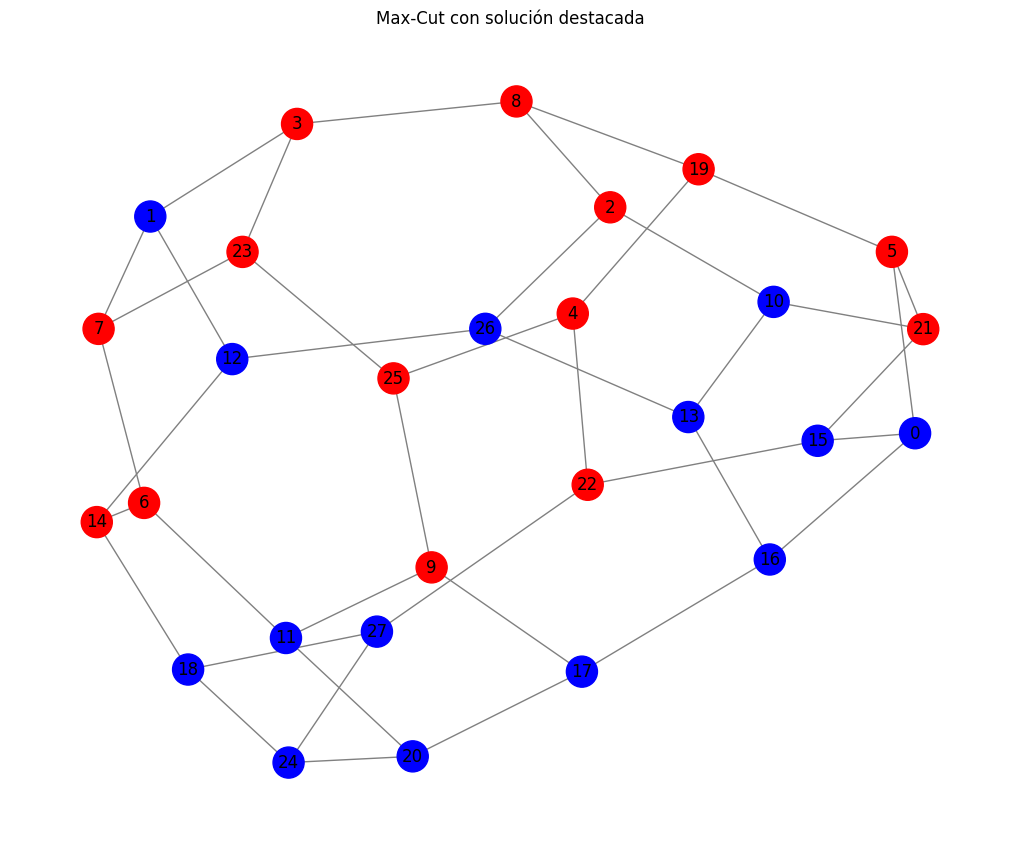

In [16]:
def analyze_solutions(G, solutions, opt_cut_value):
    best_cut_value = 0
    best_index = 0
    cut_values = []
    state_bin_list = []

    for idx, sol in enumerate(solutions):
        cut_val = compute_cut_size(G, sol)
        sol_str = ''.join(str(bit) for bit in sol)
        cut_values.append(cut_val)
        state_bin_list.append(sol_str)

        print(f"Solución {idx}: corte = {cut_val}")
        if cut_val > best_cut_value:
            best_cut_value = cut_val
            best_index = idx

    print(f"\n Mejor corte: {best_cut_value}, en la solución #{best_index}")

    # Contar ocurrencias de cada estado binario
    count_dict = Counter(state_bin_list)

    # Extraer todos los estados que lograron el corte óptimo
    # Extraer todos los estados únicos que lograron el corte óptimo
    opt_states = list({
        ''.join(str(bit) for bit in sol)
        for sol, cut in zip(solutions, cut_values)
        if cut == opt_cut_value
    })


    return best_index, best_cut_value, opt_states, count_dict

# 6. Calcular P_GS y TTS desde energías directamente
def calculate_P_GS_and_TTS_from_results(results, opt_value, t_sample, num_shots):
    counts = results["results"]["counts"]
    energies = results["results"]["energies"]
    optimal_energy = -opt_value

    total_opt_hits = sum(c for e, c in zip(energies, counts) if e == optimal_energy)
    p_gs = total_opt_hits / num_shots

    if p_gs == 1:
        tts = t_sample
    elif p_gs == 0:
        tts = float("inf")
    else:
        tts = t_sample * max(1, abs(np.log(0.01) / np.log(1 - p_gs)))

    return p_gs, tts


G = nx.random_regular_graph(d=3, n=28, seed=102)
sols = results["results"]["solutions"]
best_idx, best_cut, opt_states, count_dict = analyze_solutions(G, sols, 40)
p_gs, tts = calculate_P_GS_and_TTS_from_results(results, 40, t_sample, num_samples)

print(f"\n Métricas:")
print(f"  - t_sample (ms): {t_sample:.2f}")
print(f"  - P_GS: {p_gs:.4f}")
print(f"  - TTS (ms): {tts:.2f}")

visualize_solution(G, sols[best_idx])


In [46]:
def run_qci_maxcut(G, opt_cut_value, num_samples=30):
    # Paso 1: Construir el QUBO
    Q = build_qubo_from_graph(G)

    # Paso 2: Enviar trabajo a QCI
    job_id, client = send_qci_job(Q, num_samples=num_samples)

    # Paso 3: Esperar resultados
    results = wait_for_results(client, job_id)

    if results:
        # Paso 4: Métricas temporales
        device_time_s = results["job_info"]["job_result"]["device_usage_s"]
        t_sample = (device_time_s * 1000) / num_samples  # milisegundos por muestra

        # Paso 5: Calcular métricas desde energías
        p_gs, tts = calculate_P_GS_and_TTS_from_results(
            results, opt_cut_value, t_sample, num_samples
        )

        # Paso 6: Mostrar soluciones y mejor corte
        sols = results["results"]["solutions"]
        best_idx, best_cut, _, _ = analyze_solutions(G, sols, opt_cut_value)

        # Paso 7: Visualizar mejor solución
        visualize_solution(G, sols[best_idx])

        # Paso 8: Resultados finales
        print(f"\n Métricas:")
        print(f"  - t_sample (ms): {t_sample:.2f}")
        print(f"  - P_GS: {p_gs:.4f}")
        print(f"  - TTS (ms): {tts:.2f}")

        print(results)
        print("\nPostprocesamiento clásico (descenso local):")
        improved_sols, best_idx_post, best_cut_post, _, _ = postprocess_solutions_with_local_descent(G, sols, opt_cut_value)
        p_gs_post, tts_post = calculate_P_GS_and_TTS_from_results({"results": {"solutions": improved_sols}}, opt_cut_value, t_sample, num_samples)
        
        #  Mostrar resultados después del descenso local
        print("\n Métricas tras descenso local:")
        print(f"  - Mejor corte: {best_cut_post}")
        print(f"  - P_GS: {p_gs_post:.4f}")
        print(f"  - TTS (ms): {tts_post:.2f}")

    else:
        print(" No se pudieron obtener resultados del trabajo.")


📁 QUBO subido. File ID: 683b05ff5e0855263229b4a1
2025-05-31 15:37:04 - Dirac allocation balance = 272 s
2025-05-31 15:37:04 - Job submitted: job_id='683b0600b8b42e8edbee6b6a'
2025-05-31 15:37:04 - QUEUED
2025-05-31 15:37:07 - RUNNING
2025-05-31 15:43:57 - COMPLETED
2025-05-31 15:44:00 - Dirac allocation balance = 262 s
Trabajo enviado. Job ID: 683b0600b8b42e8edbee6b6a
Resultados obtenidos.
Solución 0: corte = 43
Solución 1: corte = 43

Mejor corte: 43, en la solución #0


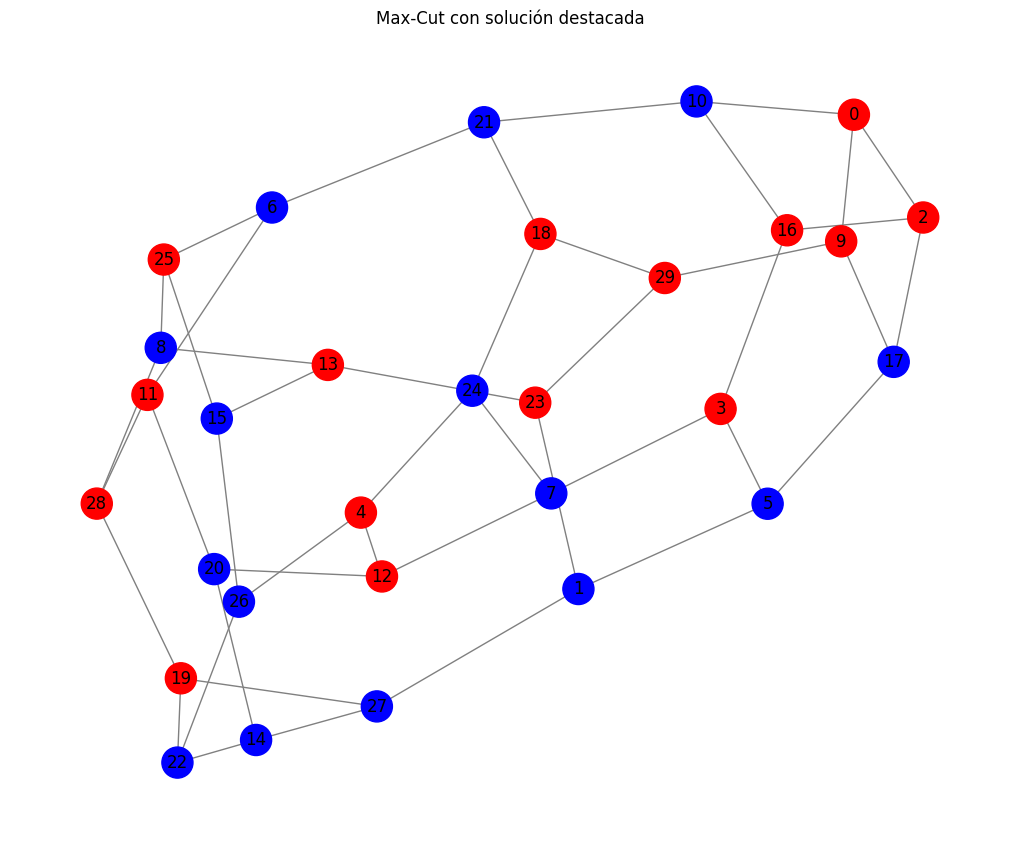


 Métricas:
  - t_sample (ms): 333.33
  - P_GS: 1.0000
  - TTS (ms): 333.33


In [20]:
G = nx.random_regular_graph(d=3, n=30, seed=264)
run_qci_maxcut(G, opt_cut_value=43, num_samples=30)

📁 QUBO subido. File ID: 683b093a5e0855263229b4a5
2025-05-31 15:50:51 - Dirac allocation balance = 262 s
2025-05-31 15:50:51 - Job submitted: job_id='683b093bb8b42e8edbee6b6b'
2025-05-31 15:50:51 - QUEUED
2025-05-31 15:50:54 - RUNNING
2025-05-31 15:53:08 - COMPLETED
2025-05-31 15:53:11 - Dirac allocation balance = 258 s
Trabajo enviado. Job ID: 683b093bb8b42e8edbee6b6b
Resultados obtenidos.
Solución 0: corte = 46
Solución 1: corte = 46

Mejor corte: 46, en la solución #0


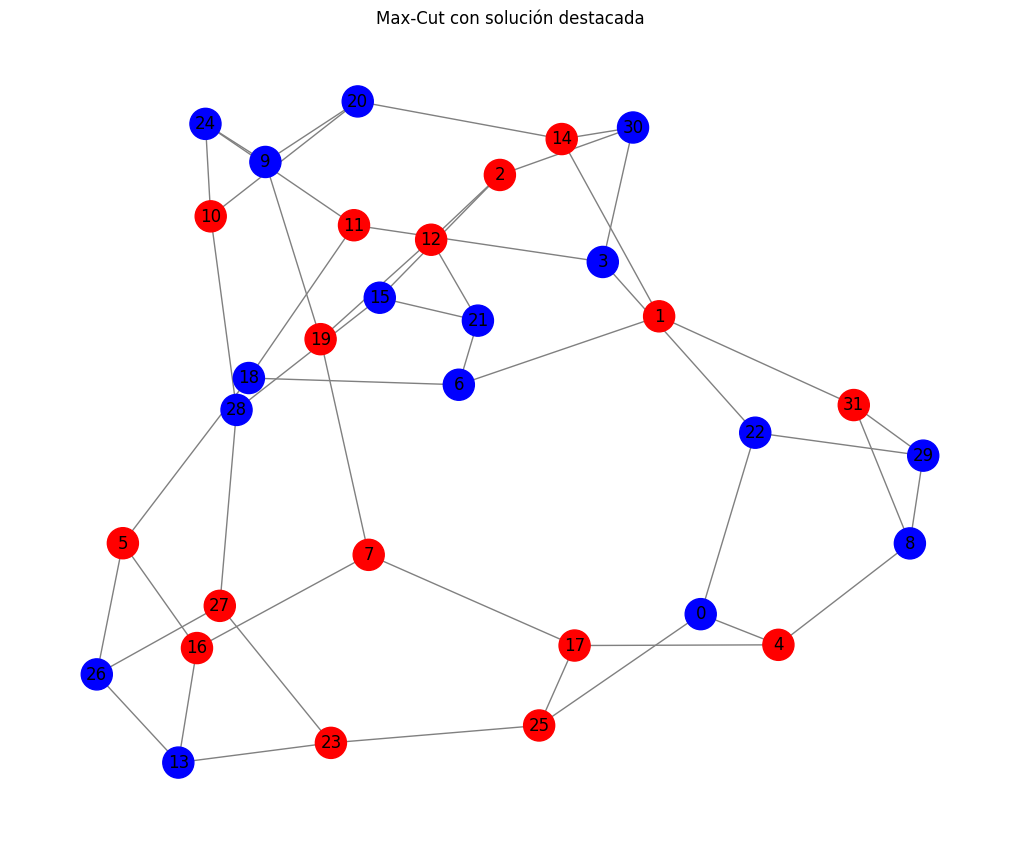


 Métricas:
  - t_sample (ms): 400.00
  - P_GS: 1.0000
  - TTS (ms): 400.00


In [22]:
G = nx.random_regular_graph(d=3, n=32, seed=7)
run_qci_maxcut(G, opt_cut_value=46, num_samples=10)

 QUBO subido. File ID: 683b0a615e0855263229b4a9
2025-05-31 15:55:45 - Dirac allocation balance = 258 s
2025-05-31 15:55:46 - Job submitted: job_id='683b0a62b8b42e8edbee6b6c'
2025-05-31 15:55:46 - QUEUED
2025-05-31 15:55:48 - RUNNING
2025-05-31 16:02:49 - COMPLETED
2025-05-31 16:02:52 - Dirac allocation balance = 240 s
Trabajo enviado. Job ID: 683b0a62b8b42e8edbee6b6c
Resultados obtenidos.
Solución 0: corte = 105
Solución 1: corte = 105
Solución 2: corte = 105
Solución 3: corte = 105
Solución 4: corte = 105
Solución 5: corte = 105
Solución 6: corte = 104
Solución 7: corte = 104
Solución 8: corte = 104
Solución 9: corte = 104
Solución 10: corte = 104
Solución 11: corte = 104
Solución 12: corte = 104
Solución 13: corte = 104
Solución 14: corte = 104
Solución 15: corte = 104
Solución 16: corte = 104
Solución 17: corte = 104
Solución 18: corte = 104
Solución 19: corte = 104
Solución 20: corte = 104
Solución 21: corte = 104
Solución 22: corte = 104
Solución 23: corte = 104
Solución 24: corte

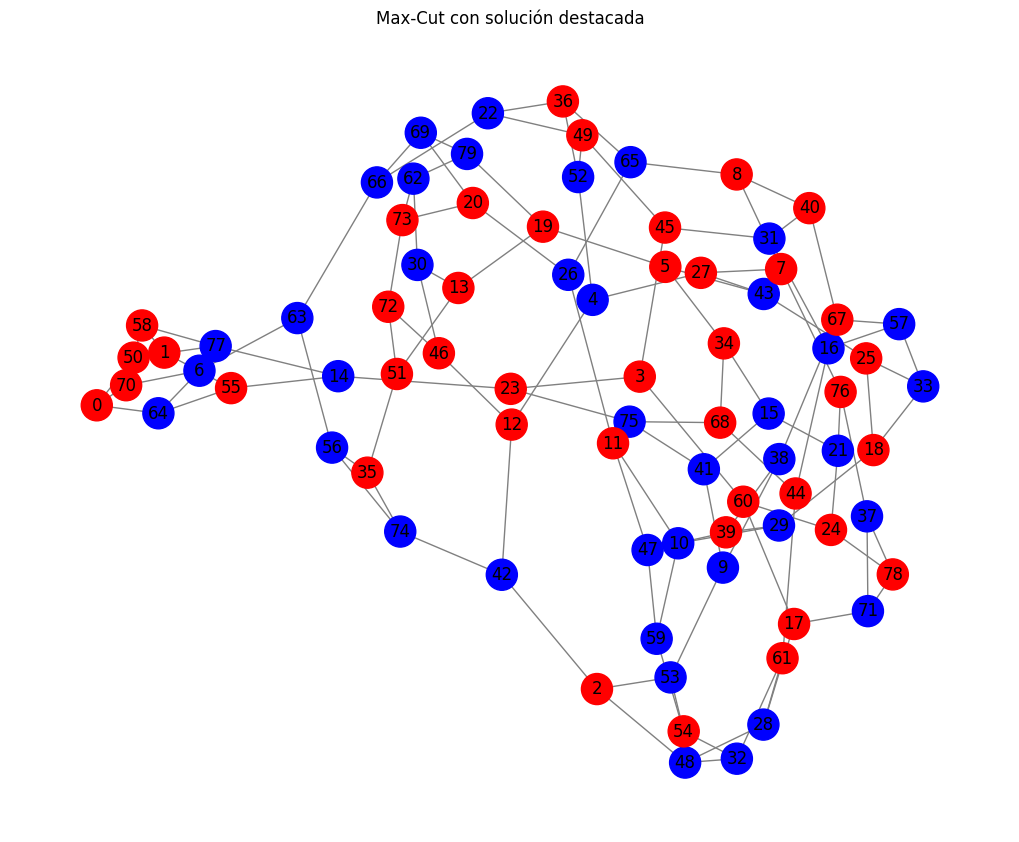


 Métricas:
  - t_sample (ms): 600.00
  - P_GS: 0.0000
  - TTS (ms): inf
{'job_info': {'job_id': '683b0a62b8b42e8edbee6b6c', 'job_submission': {'problem_config': {'quadratic_unconstrained_binary_optimization': {'qubo_file_id': '683b0a615e0855263229b4a9'}}, 'device_config': {'dirac-1': {'num_samples': 30}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-05-31T13:55:46.047Z', 'queued_at_rfc3339nano': '2025-05-31T13:55:46.048Z', 'running_at_rfc3339nano': '2025-05-31T13:55:46.57Z', 'completed_at_rfc3339nano': '2025-05-31T14:02:47.382Z'}, 'job_result': {'file_id': '683b0c075e0855263229b4ab', 'device_usage_s': 18}}, 'status': 'COMPLETED', 'results': {'counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'energies': [-105, -105, -105, -105, -105, -105, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -103, -103, -103, -103, -103, -103], 'solutions': [[0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 

In [26]:
G = nx.random_regular_graph(d=3, n=80, seed=68)
run_qci_maxcut(G, opt_cut_value=106, num_samples=30)

Solución 0: corte = 105
Solución 1: corte = 105
Solución 2: corte = 105
Solución 3: corte = 105
Solución 4: corte = 105
Solución 5: corte = 105
Solución 6: corte = 104
Solución 7: corte = 104
Solución 8: corte = 104
Solución 9: corte = 105
Solución 10: corte = 105
Solución 11: corte = 104
Solución 12: corte = 104
Solución 13: corte = 105
Solución 14: corte = 104
Solución 15: corte = 104
Solución 16: corte = 105
Solución 17: corte = 104
Solución 18: corte = 104
Solución 19: corte = 105
Solución 20: corte = 105
Solución 21: corte = 104
Solución 22: corte = 104
Solución 23: corte = 104
Solución 24: corte = 104
Solución 25: corte = 104
Solución 26: corte = 103
Solución 27: corte = 104
Solución 28: corte = 104
Solución 29: corte = 104

Mejor corte: 105, en la solución #0


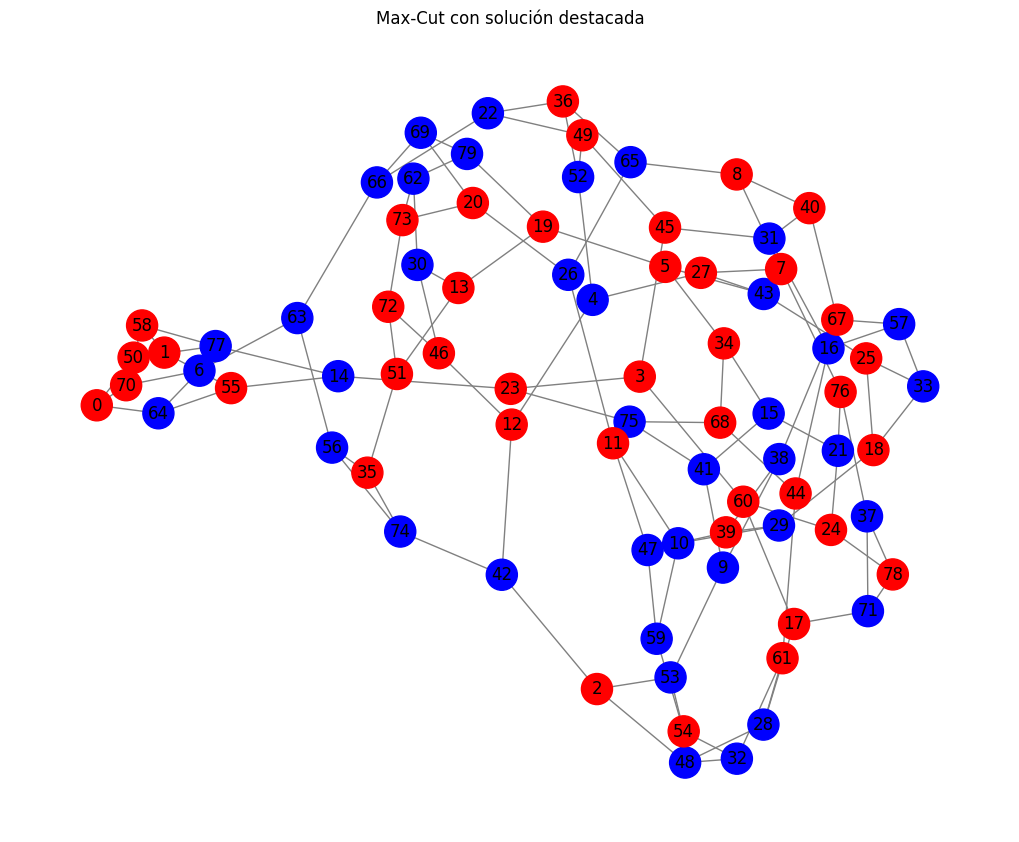

In [39]:
# Optimización local
# Asegúrate de que tienes NetworkX y tu grafo G
import numpy as np

# Convierte las soluciones a un array numpy
raw_np = np.array(solutions)

# Define tu grafo G aquí si no lo tienes todavía
# Por ejemplo, un grafo simple para pruebas:
import networkx as nx
G = nx.random_regular_graph(d=3, n=80, seed=68)

# Define un valor óptimo
opt_cut_value = 106


# Llama a la función principal
improved_solutions, best_idx, best_cut, opt_states, count_dict = postprocess_solutions_with_local_descent(
    G, raw_np, opt_cut_value
)


Solución 0: corte = 105
Solución 1: corte = 105
Solución 2: corte = 105
Solución 3: corte = 105
Solución 4: corte = 105
Solución 5: corte = 105
Solución 6: corte = 104
Solución 7: corte = 104
Solución 8: corte = 104
Solución 9: corte = 106
Solución 10: corte = 106
Solución 11: corte = 104
Solución 12: corte = 104
Solución 13: corte = 106
Solución 14: corte = 104
Solución 15: corte = 104
Solución 16: corte = 106
Solución 17: corte = 104
Solución 18: corte = 104
Solución 19: corte = 104
Solución 20: corte = 104
Solución 21: corte = 104
Solución 22: corte = 104
Solución 23: corte = 104
Solución 24: corte = 105
Solución 25: corte = 103
Solución 26: corte = 103
Solución 27: corte = 103
Solución 28: corte = 103
Solución 29: corte = 103

Mejor corte: 106, en la solución #9


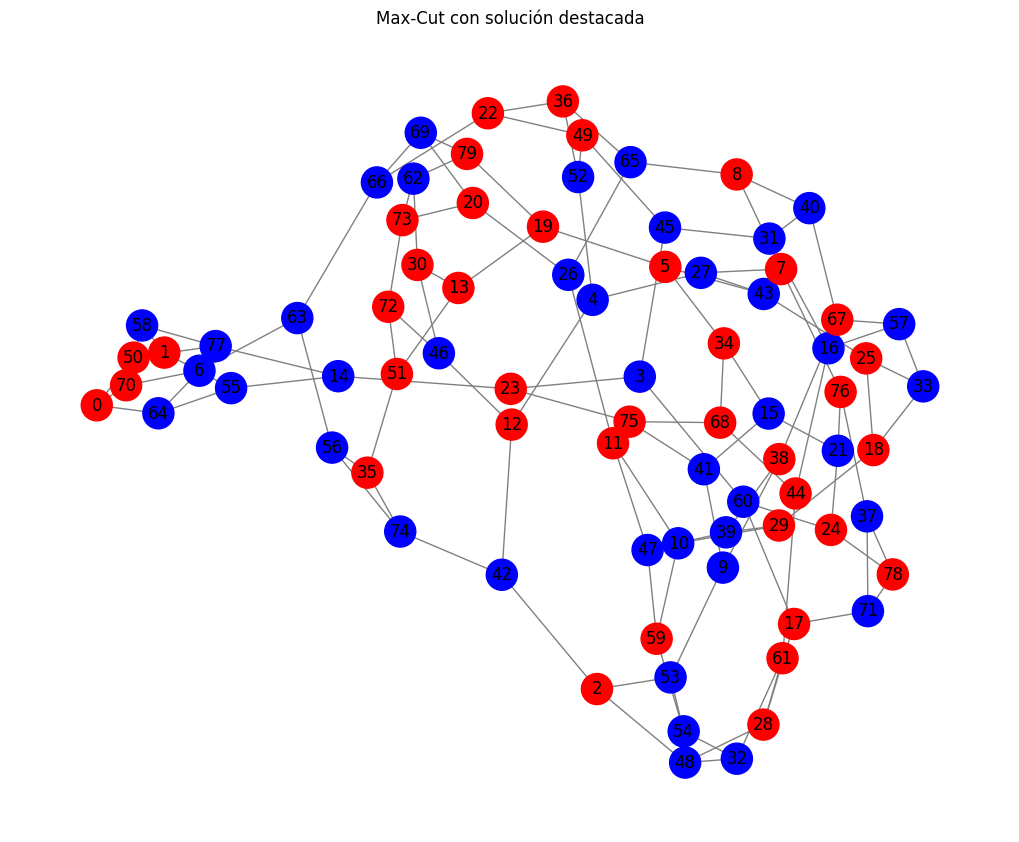


— Mejor corte tras descenso local: 106 (índice 9)

— P_GS postprocesado: 0.1333
— TTS postprocesado (ms): 19308.78 ms


In [56]:
import numpy as np

# RESULTADOS DE TU TRABAJO (ejemplo con los que has mostrado)
counts = [1]*30
energies = [-105, -105, -105, -105, -105, -105, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -103, -103, -103, -103, -103, -103]
solutions = [0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1], [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1], [0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1], [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1], [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1], [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1], [0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1], [0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1], [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0], [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1], [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1], [0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0], [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0], [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0], [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1], [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1], [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0], [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1], [1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], [1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1], [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1], [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1], [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1], [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0], [0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1], [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0], [1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1], [1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1], [1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
# ENERGÍA ÓPTIMA conocida (debes saberla por análisis previo o por brute-force)
opt_cut_value = 106
E_opt = -opt_cut_value

# Por simplicidad, crearemos un grafo completo de num_vars vértices:
# (En tu caso, usa el mismo G que generaste antes para enviar el trabajo).
G = nx.random_regular_graph(d=3, n=80, seed=68)

# 3) Conoce el valor de corte óptimo teórico (opt_cut_value)
#    Imagina que, a partir de un análisis o brute-force, sabes que el mejor corte vale 81.


# 4) Calcula t_sample (tiempo por muestra en ms)
device_time_s = 18  # desde results["job_info"]["job_result"]["device_usage_s"]
num_shots = sum(counts)  # 30
t_sample = (device_time_s * 1000) / num_shots  # en milisegundos

# 5) Aplicar POSTPROCESAMIENTO LOCAL
improved_np, best_idx_post, best_cut_post, opt_states_post, count_dict_post = \
    postprocess_solutions_with_local_descent(G, solutions, opt_cut_value)

print(f"\n— Mejor corte tras descenso local: {best_cut_post} (índice {best_idx_post})")


# 4. CALCULAR NUEVAS ENERGÍAS
Q = build_qubo_from_graph(G)
bqm = BinaryQuadraticModel.from_qubo(Q)
energies_post = bqm.energies(improved_np)

# 5. FORMAR RESULTADO ESTILO BRACKET PARA MÉTRICAS
results_post = {
    "results": {
        "counts": [1] * len(improved_np),  # suponiendo que cada solución ocurrió una vez
        "energies": list(energies_post)
    }
}

# 6. CÁLCULO DE MÉTRICAS
p_gs_post, tts_post = calculate_P_GS_and_TTS_from_results(
    results_post, opt_cut_value, t_sample, num_shots
)

print(f"\n— P_GS postprocesado: {p_gs_post:.4f}")
print(f"— TTS postprocesado (ms): {tts_post:.2f} ms")


 QUBO subido. File ID: 683b616d5e0855263229b73b
2025-05-31 22:07:10 - Dirac allocation balance = 229 s
2025-05-31 22:07:10 - Job submitted: job_id='683b616eb8b42e8edbee6c0e'
2025-05-31 22:07:11 - QUEUED
2025-05-31 22:07:13 - RUNNING
2025-05-31 22:14:16 - COMPLETED
2025-05-31 22:14:19 - Dirac allocation balance = 207 s
Trabajo enviado. Job ID: 683b616eb8b42e8edbee6c0e
Resultados obtenidos.
Solución 0: corte = 135
Solución 1: corte = 134
Solución 2: corte = 133
Solución 3: corte = 133
Solución 4: corte = 133
Solución 5: corte = 133
Solución 6: corte = 133
Solución 7: corte = 133
Solución 8: corte = 133
Solución 9: corte = 132
Solución 10: corte = 132
Solución 11: corte = 132
Solución 12: corte = 132
Solución 13: corte = 132
Solución 14: corte = 132
Solución 15: corte = 132
Solución 16: corte = 132
Solución 17: corte = 132
Solución 18: corte = 132
Solución 19: corte = 132
Solución 20: corte = 132
Solución 21: corte = 131
Solución 22: corte = 131
Solución 23: corte = 131
Solución 24: corte

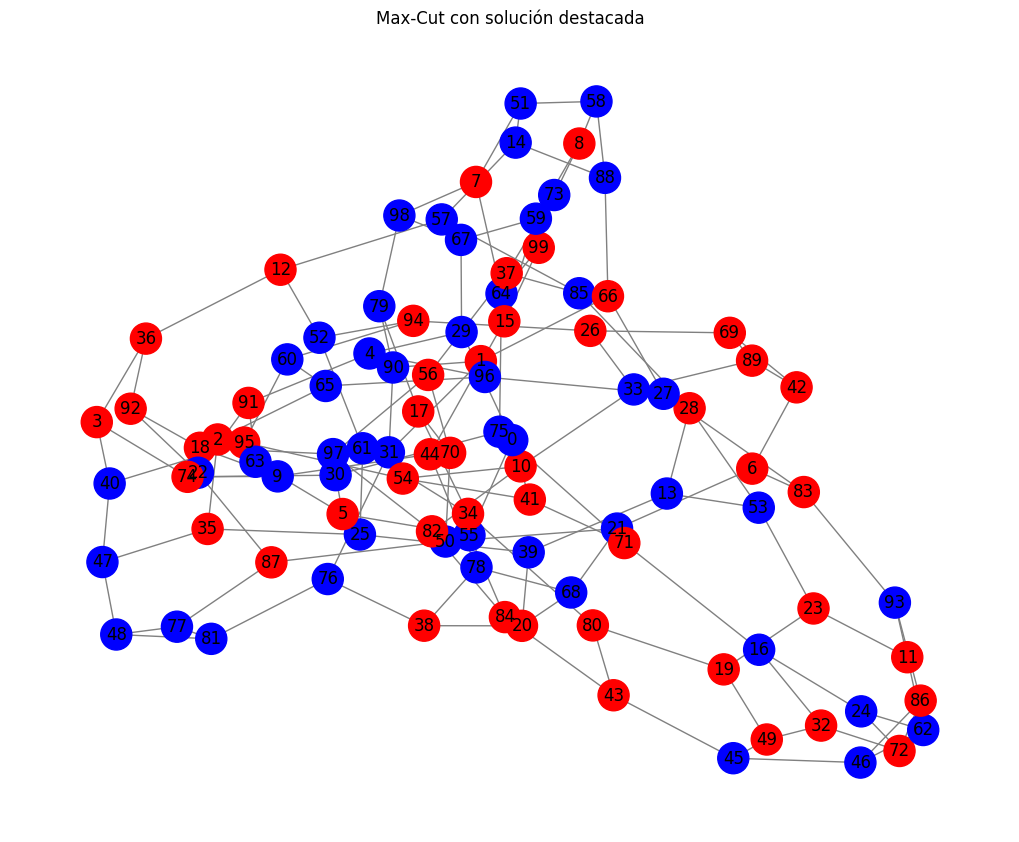


 Métricas:
  - t_sample (ms): 733.33
  - P_GS: 0.0333
  - TTS (ms): 99615.64
{'job_info': {'job_id': '683b616eb8b42e8edbee6c0e', 'job_submission': {'problem_config': {'quadratic_unconstrained_binary_optimization': {'qubo_file_id': '683b616d5e0855263229b73b'}}, 'device_config': {'dirac-1': {'num_samples': 30}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-05-31T20:07:10.821Z', 'queued_at_rfc3339nano': '2025-05-31T20:07:10.822Z', 'running_at_rfc3339nano': '2025-05-31T20:07:11.392Z', 'completed_at_rfc3339nano': '2025-05-31T20:14:16.598Z'}, 'job_result': {'file_id': '683b63185e0855263229b781', 'device_usage_s': 22}}, 'status': 'COMPLETED', 'results': {'counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'energies': [-135, -134, -133, -133, -133, -133, -133, -133, -133, -132, -132, -132, -132, -132, -132, -132, -132, -132, -132, -132, -132, -131, -131, -131, -131, -131, -131, -131, -131, -130], 'solutions': [[1, 0, 1, 1, 0, 1, 0, 1, 0, 

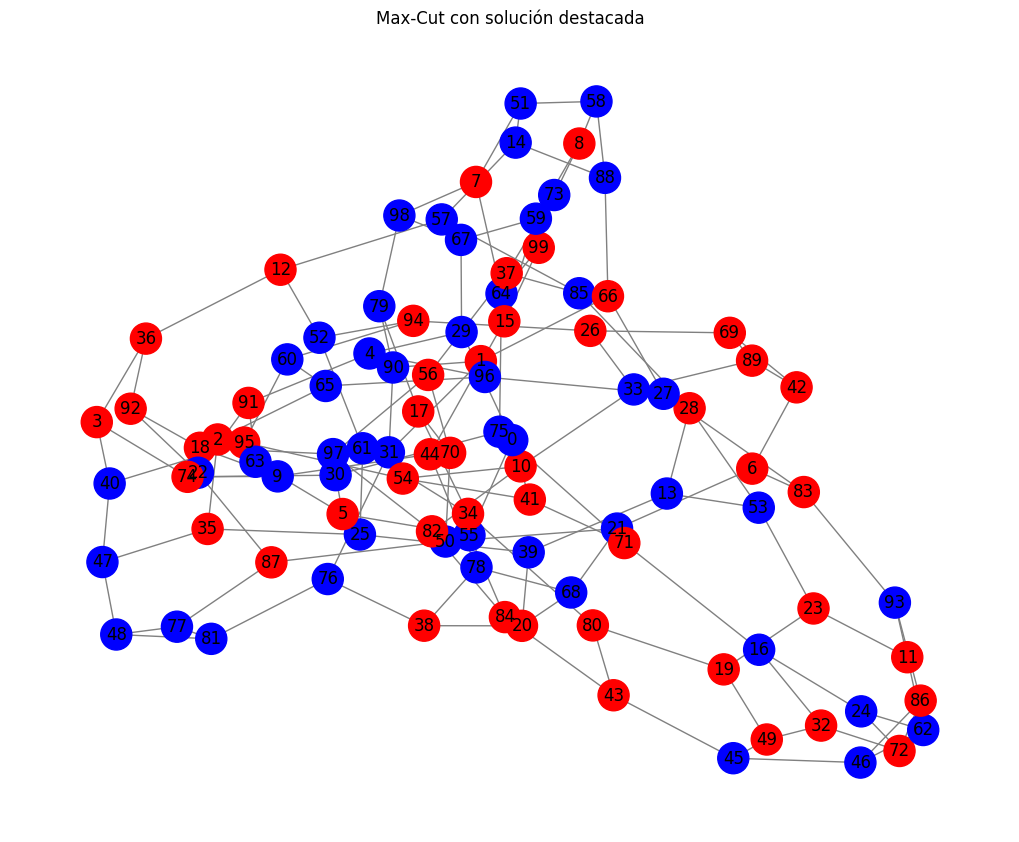

In [44]:
G = nx.random_regular_graph(d=3, n=100, seed=12)
run_qci_maxcut(G, opt_cut_value=135, num_samples=30)

Solución 0: corte = 135
Solución 1: corte = 134
Solución 2: corte = 133
Solución 3: corte = 133
Solución 4: corte = 133
Solución 5: corte = 133
Solución 6: corte = 133
Solución 7: corte = 133
Solución 8: corte = 133
Solución 9: corte = 132
Solución 10: corte = 132
Solución 11: corte = 132
Solución 12: corte = 132
Solución 13: corte = 132
Solución 14: corte = 134
Solución 15: corte = 132
Solución 16: corte = 132
Solución 17: corte = 134
Solución 18: corte = 134
Solución 19: corte = 134
Solución 20: corte = 132
Solución 21: corte = 131
Solución 22: corte = 131
Solución 23: corte = 133
Solución 24: corte = 131
Solución 25: corte = 135
Solución 26: corte = 131
Solución 27: corte = 131
Solución 28: corte = 131
Solución 29: corte = 130

Mejor corte: 135, en la solución #0


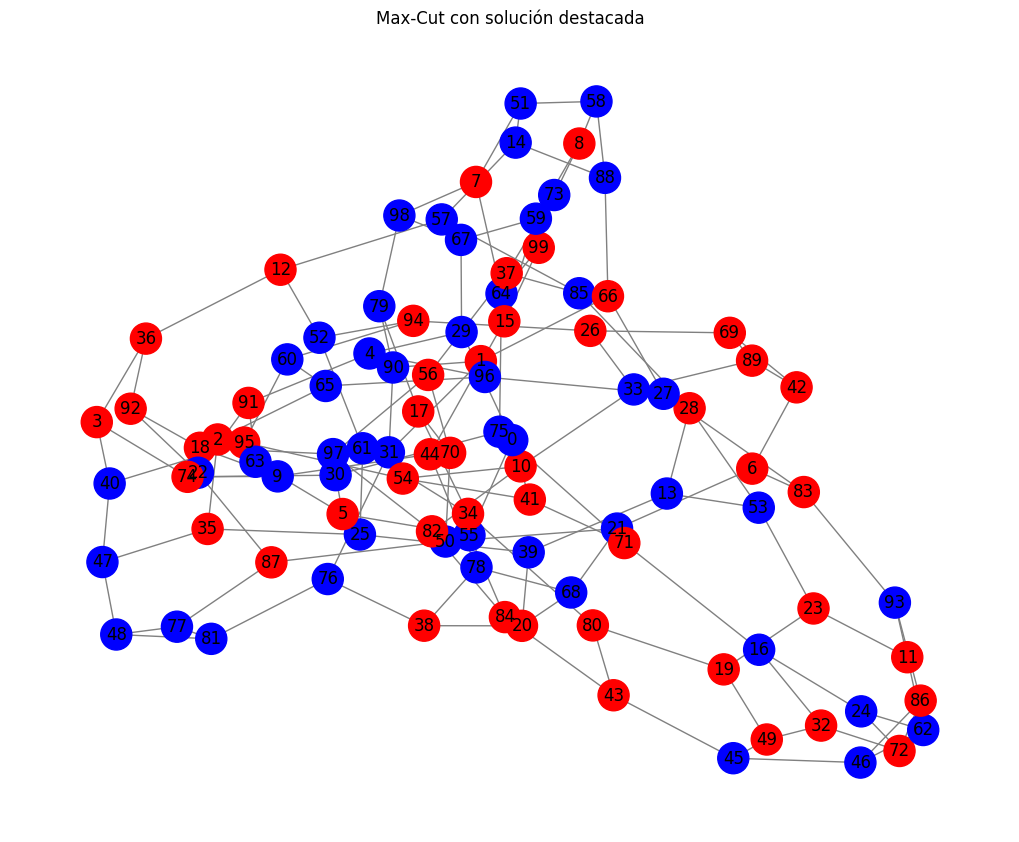


— Mejor corte tras descenso local: 135 (índice 0)

— P_GS postprocesado: 0.0667
— TTS postprocesado (ms): 48948.89 ms


In [55]:
import numpy as np

# RESULTADOS DE TU TRABAJO (ejemplo con los que has mostrado)
counts = [1]*30
energies = [-135, -134, -133, -133, -133, -133, -133, -133, -133, -132, -132, -132, -132, -132, -132, -132, -132, -132, -132, -132, -132, -131, -131, -131, -131, -131, -131, -131, -131, -130]
solutions = [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0], [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1], [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1], [0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0], [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1], [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0], [0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0], [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], [1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1], [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0], [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0], [0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1], [0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0], [1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1], [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1], [1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0], [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0], [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0], [1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1], [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1], [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1], [0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0], [1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0], [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0], [1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1], [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0], [1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0], [0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1]
# ENERGÍA ÓPTIMA conocida (debes saberla por análisis previo o por brute-force)
opt_cut_value = 135
E_opt = -opt_cut_value

# Por simplicidad, crearemos un grafo completo de num_vars vértices:
# (En tu caso, usa el mismo G que generaste antes para enviar el trabajo).
G = nx.random_regular_graph(d=3, n=100, seed=12)

# 3) Conoce el valor de corte óptimo teórico (opt_cut_value)
#    Imagina que, a partir de un análisis o brute-force, sabes que el mejor corte vale 81.


# 4) Calcula t_sample (tiempo por muestra en ms)
device_time_s = 22  # desde results["job_info"]["job_result"]["device_usage_s"]
num_shots = sum(counts)  # 30
t_sample = (device_time_s * 1000) / num_shots  # en milisegundos

# 5) Aplicar POSTPROCESAMIENTO LOCAL
improved_np, best_idx_post, best_cut_post, opt_states_post, count_dict_post = \
    postprocess_solutions_with_local_descent(G, solutions, opt_cut_value)

print(f"\n— Mejor corte tras descenso local: {best_cut_post} (índice {best_idx_post})")


# 4. CALCULAR NUEVAS ENERGÍAS
Q = build_qubo_from_graph(G)
bqm = BinaryQuadraticModel.from_qubo(Q)
energies_post = bqm.energies(improved_np)

# 5. FORMAR RESULTADO ESTILO BRACKET PARA MÉTRICAS
results_post = {
    "results": {
        "counts": [1] * len(improved_np),  # suponiendo que cada solución ocurrió una vez
        "energies": list(energies_post)
    }
}

# 6. CÁLCULO DE MÉTRICAS
p_gs_post, tts_post = calculate_P_GS_and_TTS_from_results(
    results_post, opt_cut_value, t_sample, num_shots
)

print(f"\n— P_GS postprocesado: {p_gs_post:.4f}")
print(f"— TTS postprocesado (ms): {tts_post:.2f} ms")


 QUBO subido. File ID: 683b65b95e0855263229b7f2
2025-05-31 22:25:31 - Dirac allocation balance = 207 s
2025-05-31 22:25:31 - Job submitted: job_id='683b65bbb8b42e8edbee6c3a'
2025-05-31 22:25:31 - RUNNING
2025-05-31 22:32:44 - COMPLETED
2025-05-31 22:32:47 - Dirac allocation balance = 180 s
Trabajo enviado. Job ID: 683b65bbb8b42e8edbee6c3a
Resultados obtenidos.
Solución 0: corte = 162
Solución 1: corte = 161
Solución 2: corte = 161
Solución 3: corte = 161
Solución 4: corte = 161
Solución 5: corte = 161
Solución 6: corte = 160
Solución 7: corte = 160
Solución 8: corte = 160
Solución 9: corte = 160
Solución 10: corte = 160
Solución 11: corte = 160
Solución 12: corte = 160
Solución 13: corte = 159
Solución 14: corte = 159
Solución 15: corte = 159
Solución 16: corte = 159
Solución 17: corte = 159
Solución 18: corte = 159
Solución 19: corte = 159
Solución 20: corte = 159
Solución 21: corte = 159
Solución 22: corte = 158
Solución 23: corte = 158
Solución 24: corte = 158
Solución 25: corte = 1

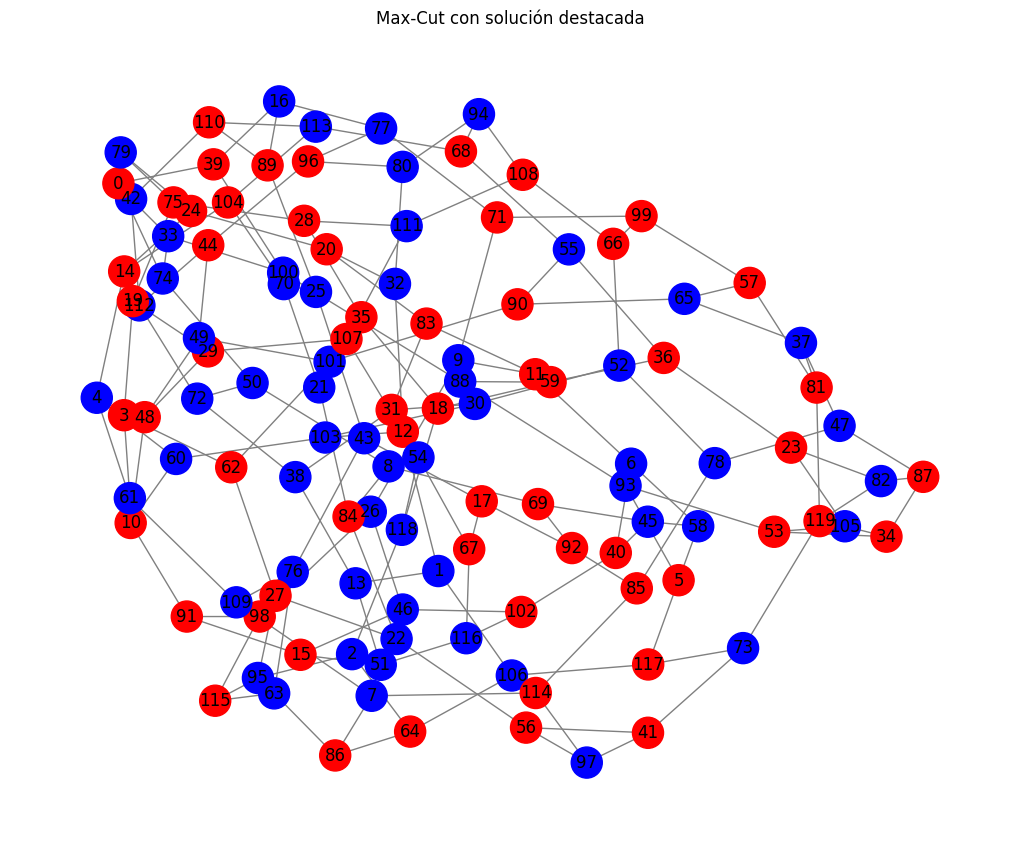


 Métricas:
  - t_sample (ms): 900.00
  - P_GS: 0.0000
  - TTS (ms): inf
{'job_info': {'job_id': '683b65bbb8b42e8edbee6c3a', 'job_submission': {'problem_config': {'quadratic_unconstrained_binary_optimization': {'qubo_file_id': '683b65b95e0855263229b7f2'}}, 'device_config': {'dirac-1': {'num_samples': 30}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-05-31T20:25:31.145Z', 'queued_at_rfc3339nano': '2025-05-31T20:25:31.146Z', 'running_at_rfc3339nano': '2025-05-31T20:25:31.197Z', 'completed_at_rfc3339nano': '2025-05-31T20:32:41.958Z'}, 'job_result': {'file_id': '683b67695e0855263229b81c', 'device_usage_s': 27}}, 'status': 'COMPLETED', 'results': {'counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'energies': [-162, -161, -161, -161, -161, -161, -160, -160, -160, -160, -160, -160, -160, -159, -159, -159, -159, -159, -159, -159, -159, -159, -158, -158, -158, -158, -157, -157, -157, -155], 'solutions': [[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,

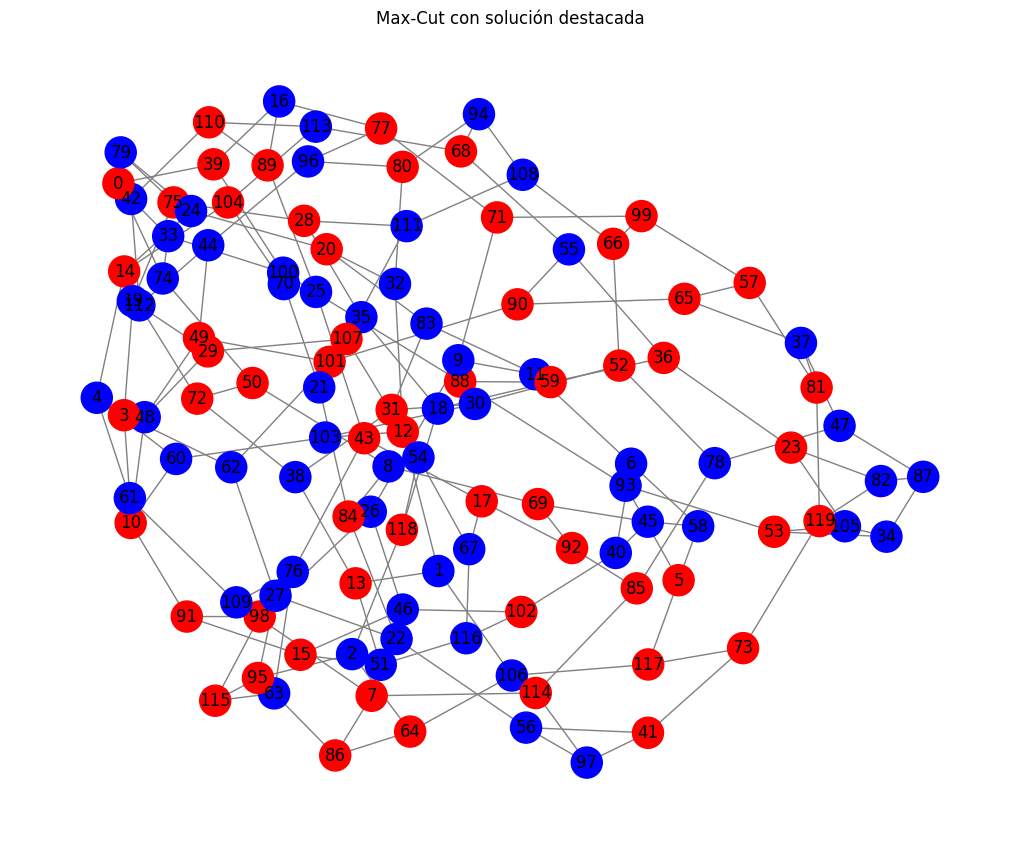

In [45]:
G = nx.random_regular_graph(d=3, n=120, seed=8)
run_qci_maxcut(G, opt_cut_value=163, num_samples=30)

Solución 0: corte = 162
Solución 1: corte = 163
Solución 2: corte = 161
Solución 3: corte = 161
Solución 4: corte = 163
Solución 5: corte = 161
Solución 6: corte = 162
Solución 7: corte = 162
Solución 8: corte = 160
Solución 9: corte = 162
Solución 10: corte = 162
Solución 11: corte = 160
Solución 12: corte = 160
Solución 13: corte = 161
Solución 14: corte = 159
Solución 15: corte = 159
Solución 16: corte = 159
Solución 17: corte = 159
Solución 18: corte = 161
Solución 19: corte = 161
Solución 20: corte = 159
Solución 21: corte = 159
Solución 22: corte = 160
Solución 23: corte = 158
Solución 24: corte = 160
Solución 25: corte = 158
Solución 26: corte = 159
Solución 27: corte = 161
Solución 28: corte = 157
Solución 29: corte = 155

Mejor corte: 163, en la solución #1


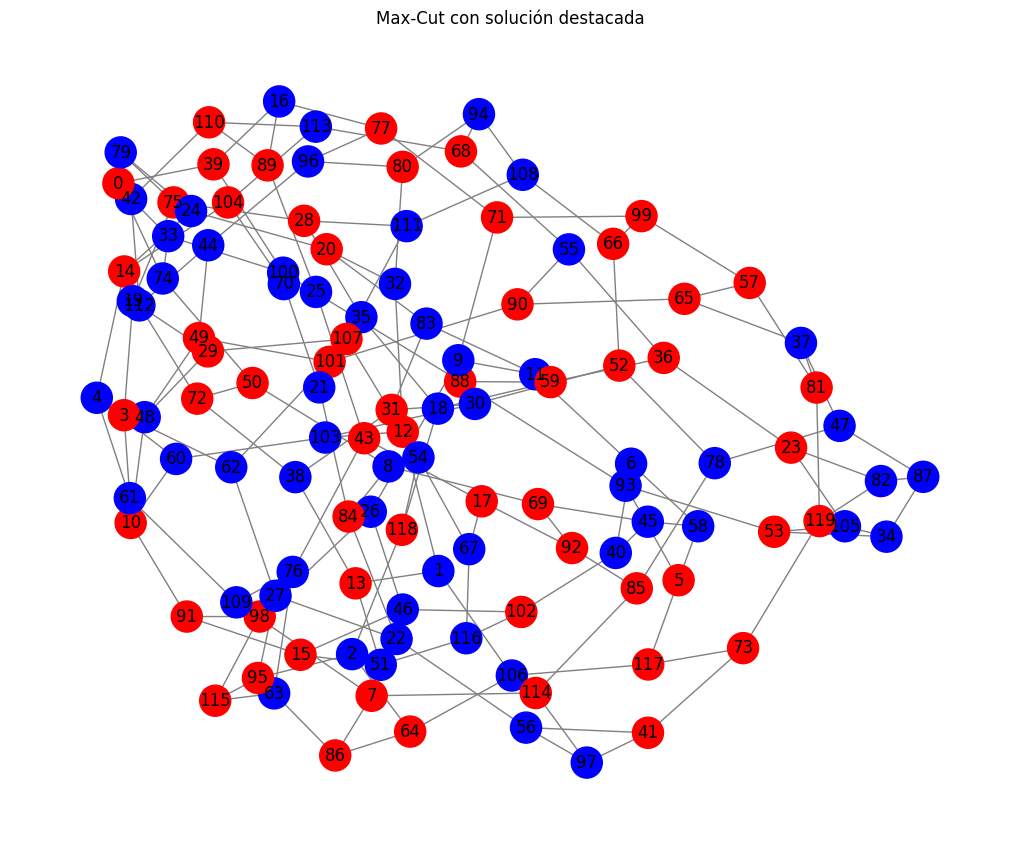


— Mejor corte tras descenso local: 163 (índice 1)

— P_GS postprocesado: 0.0667
— TTS postprocesado (ms): 60073.64 ms


In [52]:
import numpy as np

# RESULTADOS DE TU TRABAJO (ejemplo con los que has mostrado)
counts = [1]*30
energies = [-162, -161, -161, -161, -161, -161, -160, -160, -160, -160,
            -160, -160, -160, -159, -159, -159, -159, -159, -159, -159,
            -159, -159, -158, -158, -158, -158, -157, -157, -157, -155]
solutions = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0], [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0], [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1], [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1], [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0], [0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0], [1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0], [1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1], [1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0], [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1], [0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0], [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0], [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1], [1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0], [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1], [1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1], [1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0], [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1], [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0], [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0], [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0], [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0], [1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1]  # Puedes ignorar esto si solo quieres P_GS y TTS

# ENERGÍA ÓPTIMA conocida (debes saberla por análisis previo o por brute-force)
opt_cut_value = 163
E_opt = -opt_cut_value

# Por simplicidad, crearemos un grafo completo de num_vars vértices:
# (En tu caso, usa el mismo G que generaste antes para enviar el trabajo).
G = nx.random_regular_graph(d=3, n=120, seed=8)

# 3) Conoce el valor de corte óptimo teórico (opt_cut_value)
#    Imagina que, a partir de un análisis o brute-force, sabes que el mejor corte vale 81.


# 4) Calcula t_sample (tiempo por muestra en ms)
device_time_s = 27  # desde results["job_info"]["job_result"]["device_usage_s"]
num_shots = sum(counts)  # 30
t_sample = (device_time_s * 1000) / num_shots  # en milisegundos

# 5) Aplicar POSTPROCESAMIENTO LOCAL
improved_np, best_idx_post, best_cut_post, opt_states_post, count_dict_post = \
    postprocess_solutions_with_local_descent(G, solutions, opt_cut_value)

print(f"\n— Mejor corte tras descenso local: {best_cut_post} (índice {best_idx_post})")


# 4. CALCULAR NUEVAS ENERGÍAS
Q = build_qubo_from_graph(G)
bqm = BinaryQuadraticModel.from_qubo(Q)
energies_post = bqm.energies(improved_np)

# 5. FORMAR RESULTADO ESTILO BRACKET PARA MÉTRICAS
results_post = {
    "results": {
        "counts": [1] * len(improved_np),  # suponiendo que cada solución ocurrió una vez
        "energies": list(energies_post)
    }
}

# 6. CÁLCULO DE MÉTRICAS
p_gs_post, tts_post = calculate_P_GS_and_TTS_from_results(
    results_post, opt_cut_value, t_sample, num_shots
)

print(f"\n— P_GS postprocesado: {p_gs_post:.4f}")
print(f"— TTS postprocesado (ms): {tts_post:.2f} ms")


In [ ]:
# Grafos que ejecutar
""" 
graphs = [
    nx.random_regular_graph(d=3, n=28, seed=102),
    nx.random_regular_graph(d=3, n=30, seed=264),
    nx.random_regular_graph(d=3, n=32, seed=7),
    nx.random_regular_graph(d=3, n=80, seed=68),
    nx.random_regular_graph(d=3, n=100, seed=12),
    nx.random_regular_graph(d=3, n=120, seed=8),
]
opt = [40, 43, 46, 106, 135, 163]
"""